<a href="https://colab.research.google.com/github/liadekel/analyzing-big-data/blob/master/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework Assignment 8

**Question 1:** Select a book or a movie's subtitle, and find the locations that appear in the book/movie. Then, draw these locations on a map (at least 10 locations) (30pt). Connect the discovered locations with lines according to their order of appearance
in the book. For example, if location B appeared immediately after location A, then draw a line connecting locations A and B (20pt).

In [2]:
!pip install turicreate
!pip install spaCy
!pip install pymongo
!pip install geopandas
!pip install descartes
!pip install geopy
!pip install folium
!pip install imageio
!pip install dnspython

# Run this to make cartopy work with colab 
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install --no-binary shapely shapely --force
!pip install afinn
!pip install nltk
!pip install plotly_express

!python -m spacy download en_core_web_lg # Important! you need to restart runtime after install

     |████████████████████████████████| 91.9MB 93kB/s 
     |████████████████████████████████| 86.3MB 62kB/s 
     |████████████████████████████████| 3.4MB 34.7MB/s 
     |████████████████████████████████| 327kB 18.8MB/s 
     |████████████████████████████████| 450kB 29.7MB/s 
     |████████████████████████████████| 3.8MB 34.4MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=16024f76ed2e4795861ddde14ee87ad96b5493ecf9197519c4671d2c961b0620
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b0adbd29bdb1320e5ba96e3ab6dfdd2440c29ba2709ec6f4eb8e1114d5ad32a9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built resampy gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Fo

In [3]:
#setting up Kaggle & TuriCreate package s
import json
import os

!mkdir /root/.kaggle/
# Installing the Kaggle package

#Important Note: 
# complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"liaddekel","key":"bf0297555b2915c6c31a8f6579de9483"}

# creating kaggle.json file with the personal API-Key details 
# You can also put this file on your Google Drive

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [4]:
#!mkdir ./datasets
!mkdir ./datasets/tarantino
# download the dataset from Kaggle and unzip it
!kaggle datasets download aadityanaik/shakespeareworks -p ./datasets/tarantino
!unzip ./datasets/tarantino/*.zip  -d ./datasets/tarantino
! ls -l ./datasets/tarantino/

mkdir: cannot create directory ‘./datasets/tarantino’: No such file or directory
  0% 0.00/514k [00:00<?, ?B/s]
100% 514k/514k [00:00<00:00, 35.7MB/s]
Archive:  ./datasets/tarantino/shakespeareworks.zip
  inflating: ./datasets/tarantino/django_unchained_script.txt  
  inflating: ./datasets/tarantino/inglorious_basterds_script.txt  
  inflating: ./datasets/tarantino/pulp_fiction_script.txt  
  inflating: ./datasets/tarantino/reservoir_dogs_screenplay.txt  
  inflating: ./datasets/tarantino/tarantino_scripts.txt  
total 1840
-rw-r--r-- 1 root root 218966 Oct  3  2019 django_unchained_script.txt
-rw-r--r-- 1 root root 199581 Oct  3  2019 inglorious_basterds_script.txt
-rw-r--r-- 1 root root 154775 Oct  3  2019 pulp_fiction_script.txt
-rw-r--r-- 1 root root 102365 Oct  3  2019 reservoir_dogs_screenplay.txt
-rw-r--r-- 1 root root 526151 Jun  3 11:08 shakespeareworks.zip
-rw-r--r-- 1 root root 675687 Oct  3  2019 tarantino_scripts.txt


In [1]:
import spacy
nlp = spacy.load('en_core_web_lg')

dogs_path = './datasets/tarantino/reservoir_dogs_screenplay.txt'

def get_entites_dict_from_text(text):
    entities_dict= {}
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if  label not in entities_dict:
            entities_dict[label] = {}
        if e not in entities_dict[label]:
            entities_dict[label][e] = 0
        entities_dict[label][e] += 1
    return entities_dict

dogs_txt = open(dogs_path,"r", encoding="utf8", errors="ignore").read()
e  = get_entites_dict_from_text(dogs_txt)
locations = list(e['GPE'])
locations

['greenbay',
 'china',
 'coon',
 'georgia',
 'the\nfuck outta',
 'costa rica',
 'nice',
 'p.o.',
 'long\nbeach',
 'vegas',
 'hamburg',
 'chicago',
 'holdaway',
 'gardena',
 'outta town',
 'wisconsin',
 'milwaukee',
 'portland',
 'los angeles',
 'santa cruz',
 'v.o.',
 'los angeles county\n',
 'los angeles county',
 'l.a.',
 'sacramento',
 'jodie',
 'gibraltar',
 'ladora heights',
 'beverly hills',
 'ladora heights\n',
 'palos verdes',
 'brooklyn',
 'poland',
 'st. petersburg',
 'b.g.']

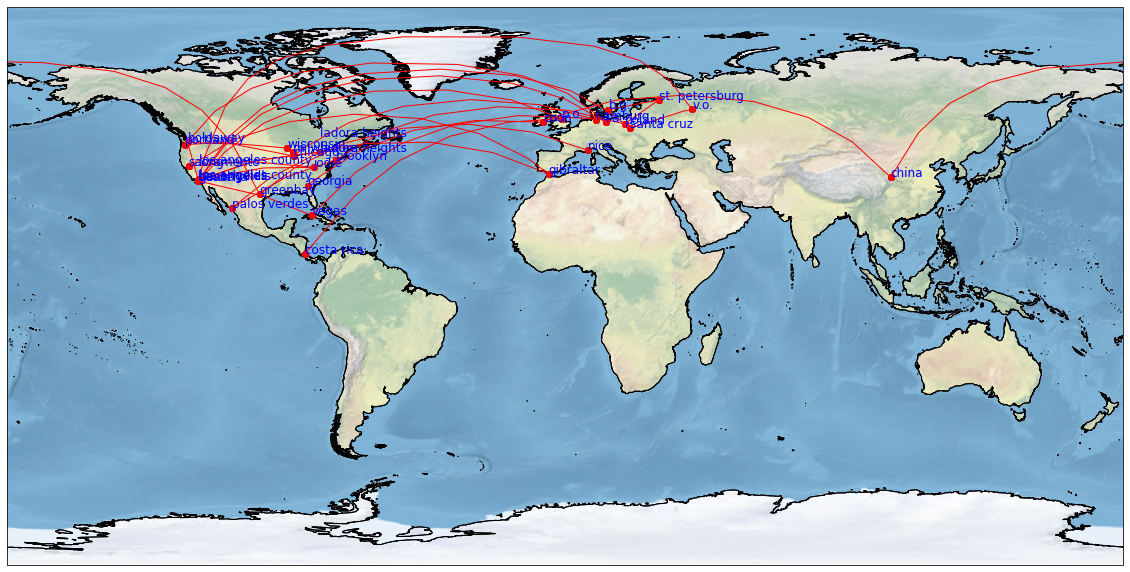

In [3]:
from geopy import Nominatim
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

geolocator = Nominatim()

plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines(resolution='10m', color='black', linewidth=1) # draw with batter coaslines resolution
ax.stock_img() # add colors 

for l in locations:
    location = geolocator.geocode(l)
    if location:
        lon, lat, name =  location.longitude, location.latitude, l
        plt.plot(lon, lat,
            color='black', marker='o', markersize=6,transform=ccrs.PlateCarree(),
            )
        ax.text(lon, lat+0.2, name, fontsize=12, color="blue", transform=ccrs.PlateCarree(),)

ax.coastlines(resolution='10m', color='black', linewidth=1) # draw with batter coaslines resolution

# we will determine the order of apperance by the index
# of first occurence of each location
location_index = {}
for l in locations:
    try:
        location_index[l] = dogs_txt.lower().index(l)
    except:
        pass
location_index

import operator
# sort by index of substring
sorted_locations = list(sorted(location_index.items(), key=operator.itemgetter(1)))

# draw lines by each two following items
for i in range(len(sorted_locations) - 1):
    a = geolocator.geocode(sorted_locations[i][0])
    b = geolocator.geocode(sorted_locations[i+1][0])

    if a and b:
        plt.plot([a.longitude, b.longitude], [a.latitude, b.latitude],
            color='red', linewidth=1, marker='o',
            transform=ccrs.Geodetic(),
            )

**Question 2:** Select a country's' statistic from the [World Development Indicators dataset](https://www.kaggle.com/worldbank/world-development-indicators) (Please notice there are several files in the dataset, such as _Indicators.csv_).
Then, create a choropleth map displaying how the selected statistics changed over time (15pt) 
    
**Bonus:** Create a short animation that displays how the chosen statistics changed over time (15pt)

**Question 3:** Select a request type from [San Francisco 311 dataset](https://www.kaggle.com/datasf/case-data-from-san-francisco-311).
Create an interactive map that somehow presents in which areas this request occurs the most (35pt).

In [8]:
!pip install pyshp
!pip install pandas
!pip install folium

In [7]:
!mkdir datasets/san-francisco
!kaggle datasets download datasf/case-data-from-san-francisco-311 -p ./datasets/san-francisco
!unzip ./datasets/san-francisco/*.zip  -d ./datasets/san-francisco/

 90% 110M/122M [00:00<00:00, 121MB/s] 
100% 122M/122M [00:01<00:00, 122MB/s]
Archive:  ./datasets/san-francisco/case-data-from-san-francisco-311.zip
  inflating: ./datasets/san-francisco/Case_Data_from_San_Francisco_311__SF311.csv  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.dbf  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.prj  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.shp  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.shx  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Supervisor Districts as of April 2012/geo_export_38fd3153-0303-488e-9f3c-0f81e8e00115.dbf  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Supervisor Districts as of April 2012/geo_export_

In [9]:
import turicreate as tc
sf = tc.SFrame.read_csv('./datasets/san-francisco/Case_Data_from_San_Francisco_311__SF311.csv')
sf

Finished parsing file /content/datasets/san-francisco/Case_Data_from_San_Francisco_311__SF311.csv

Parsing completed. Parsed 100 lines in 2.30883 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,str,str,str,str,str,str,str,str,int,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 189228 lines. Lines per second: 99128

Unexpected characters after last column. "Abandoned Vehicle - Car4door"
Parse failed at token ending at: 
	s Work Queue,Abandoned Vehicle,Abandoned Vehicle - Car4door,^Gray - Volkswagen -  - 7MJV079,Intersection of 2
Successfully parsed 16 tokens: 
	0: 5526685
	1: 02/02/2016 ... 5:55:47 AM
	2: 02/03/2016 ... 1:21:40 AM
	3: 02/03/2016 ... 1:21:40 AM
	4: Closed
	5: "Case Reso ... 1256715196
	6: -122.391840449142)"
	7: Voice In
	8: 5698025
	9: 03/24/2016 ... 8:34:48 PM
	10: 03/29/2016 ... 8:25:01 AM
	11: 3
	12: Closed
	13: DPT Abando ...       #229
	14: DPT Abando ... Work Queue
	15: Abandoned Vehicle

Unable to interpret "Environmental Health-DPH" as a integer
Parse failed at token ending at: 
	 Environmental Health-DPH^
Successfully parsed 0 tokens:

Unable to interpret "(415)-252-380"" as a integer
Parse failed at token ending at: 
	 (415)-252-380",^DPH - Environmental Health - G,General Requests,
Successfully parsed 0 tokens:

Unable to interpret "Environmental Health-DPH" as a integer
Parse failed at token ending at: 
	 Environmental Health-DPH^
Successfully parsed 0 tokens:

Unable to interpret "(415)-252-380"" as a integer
Parse failed at token ending at: 
	 (415)-252-380",^DPH - Environmental Health - G,Noise Report,mech
Successfully parsed 0 tokens:

Unexpected characters after last column. "DPW Ops Queue"
Parse failed at token ending at: 
	:00:36 AM,Closed,Case Resolved - duplicate sr,DPW Ops Queue,^Street and Sidewalk Cleaning,Illegal Encampment,
Successfully parsed 16 tokens: 
	0: 415
	1: DPH - Envi ... Health - G
	2: Street and ... k Cleaning
	3: Hazardous Materials
	4: Needles
	5: Intersecti ... and 8TH ST
	6: 10
	7: Showplace Square
	8: (37.767300 ... 428647996)
	9: Voice In
	10: 5698219
	11: 3
	12: 03/25/2016 ... 7:00:36 AM
	13: 03/25/2016 ... 7:00:36 AM
	14: Closed
	15: Case Resol ... plicate sr

Unexpected characters after last column. "DPW Ops Queue"
Parse failed at token ending at: 
	/2016 01:00:00 AM,Closed,Case Resolved - done,DPW Ops Queue,^Street and Sidewalk Cleaning,Hazardous Materials
Successfully parsed 16 tokens: 
	0: 415
	1: DPH - Envi ... Health - G
	2: Street and ... k Cleaning
	3: Hazardous Materials
	4: Needles
	5: Intersecti ...  HOWARD ST
	6: 6
	7: South of Market
	8: (37.773100 ... 561380814)
	9: Voice In
	10: 5698609
	11: 3
	12: 03/29/2016 ... 1:00:00 AM
	13: 03/29/2016 ... 1:00:00 AM
	14: Closed
	15: Case Resolved - done

Unable to interpret "Environmental Health-DPH" as a integer
Parse failed at token ending at: 
	 Environmental Health-DPH^
Successfully parsed 0 tokens:

Unable to interpret "(415)-252-380"" as a integer
Parse failed at token ending at: 
	 (415)-252-380",^DPH - Environmental Health - G,Noise Report,garb
Successfully parsed 0 tokens:

Unable to interpret "Environmental Health-DPH" as a integer
Parse failed at token ending at: 
	 Environmental Health-DPH^
Successfully parsed 0 tokens:

Read 1043264 lines. Lines per second: 148691

16596 lines failed to parse correctly

Finished parsing file /content/datasets/san-francisco/Case_Data_from_San_Francisco_311__SF311.csv

Parsing completed. Parsed 1161482 lines in 8.70908 secs.

Columns:
	CaseID	int
	Opened	str
	Closed	str
	Updated	str
	Status	str
	Status Notes	str
	Responsible Agency	str
	Category	str
	Request Type	str
	Request Details	str
	Address	str
	Supervisor District	int
	Neighborhood	str
	Point	str
	Source	str
	Media URL	str

Rows: 1161482

Data:
+--------+------------------------+------------------------+
| CaseID |         Opened         |         Closed         |
+--------+------------------------+------------------------+
| 322571 | 11/30/2008 11:53:00 PM | 12/01/2008 03:19:00 PM |
| 322568 | 11/30/2008 11:13:00 PM | 07/21/2009 04:24:00 PM |
| 322567 | 11/30/2008 11:07:00 PM | 12/27/2008 06:07:00 AM |
| 322566 | 11/30/2008 10:56:00 PM | 07/21/2009 04:24:00 PM |
| 322565 | 11/30/2008 10:46:00 PM | 12/13/2008 10:50:00 AM |
| 322564 | 11/30/2008 10:43:00 PM | 12/01/2008 04:07:00 PM |
| 322560 | 11/30/2008 10:24:00 PM | 07/21/2009 04:24:00 PM |
| 322559 | 11/30/2008 10:20:00 PM | 12/01/2008 06:07:00 AM |
| 322558 | 11/30/2008 10:04:00 PM | 11/30/2008 10:18:00 PM |
| 322556 | 11/30/2008 09:34:00 PM | 12/09/2008 08:07:00 AM |
+--------+------------------------+------------------------+
+------------------------+--------+--------------+
|        Updated         | Status | Status Notes |
+------------------------+--------+--------------+
| 12/01/2008 03:19:00 PM | Closed |              |
| 07/21/2009 04:24:00 PM | Closed |              |
| 12/27/2008 06:07:00 AM | Closed |              |
| 07/21/2009 04:24:00 PM | Closed |              |
| 12/13/2008 10:50:00 AM | Closed |              |
| 12/01/2008 04:07:00 PM | Closed |              |
| 07/21/2009 04:24:00 PM | Closed |              |
| 12/01/2008 06:07:00 AM | Closed |              |
| 11/30/2008 10:18:00 PM | Closed |              |
| 12/09/2008 08:07:00 AM | Closed |              |
+------------------------+--------+--------------+
+-------------------------------+------------------------------+
|       Responsible Agency      |           Category           |
+-------------------------------+------------------------------+
|    PUC - Electric/Power - G   |       General Requests       |
|         DPW Ops Queue         |       Illegal Postings       |
|         DPW Ops Queue         |       Illegal Postings       |
|         DPW Ops Queue         | Street and Sidewalk Cleaning |
| RPD Park Service Area GGP ... |    Rec and Park Requests     |
|         DPW Ops Queue         |   Graffiti Public Property   |
|         DPW Ops Queue         | Street and Sidewalk Cleaning |
|         DPW Ops Queue         | Street and Sidewalk Cleaning |
|   311 Service Request Queue   |     311 External Request     |
|         DPW Ops Queue         | Street and Sidewalk Cleaning |
+-------------------------------+------------------------------+
+-------------------------------+--------------------------------+
|          Request Type         |        Request Details         |
+-------------------------------+--------------------------------+
| puc - electric - request_f... | puc - electric - request_f...  |
| Illegal Postings - Posting... | Posting_Too_Large_in_Size ...  |
| Illegal Postings - Affixed... | Affixed_Improperly on Sidewalk |
|       Sidewalk_Cleaning       |            Garbage             |
| Park - Structural_Maintenance |             Other              |
| Offensive Graffiti on Publ... | Other_enter_additional_det...  |
|        Illegal_Dumping        |            Garbage             |
|        Illegal_Dumping        |            Mattress            |
|        Damaged_Property       |                                |
|       Sidewalk_Cleaning       |      Human_waste_or_urine      |
+-------------------------------+--------------------------------+
+-------------------------------+---------------------+-----------------------+
|            Address            | Supervisor District |      Neighborhood     |
+-------------------------------+---------------------+-----------------------+
| Intersection of 21ST ST an... |          9          |        

In [0]:
# filter only specific type of request
sf = sf.filter_by('General Cleaning', 'Request Type')

In [0]:
from turicreate import aggregate as agg
count_sf = sf.groupby('Neighborhood', {'Count': agg.COUNT()})
count_sf

Columns:
	Neighborhood	str
	Count	int

Rows: 38

Data:
+-----------------------+-------+
|      Neighborhood     | Count |
+-----------------------+-------+
| Downtown/Civic Center |  2624 |
|        Parkside       |  684  |
|        Bayview        |  4934 |
|         Marina        |  675  |
|       Chinatown       |  244  |
|                       |   26  |
|       Ocean View      |  2048 |
|      Outer Sunset     |  1402 |
|     Inner Richmond    |  1277 |
|    Golden Gate Park   |  224  |
+-----------------------+-------+
[38 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
import shapefile
import json

# read the shapefile
reader = shapefile.Reader('datasets/san_francisco_311/Shapefiles (2)/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.shp')
fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []
for sr in reader.shapeRecords():
   atr = dict(zip(field_names, sr.record))
   geom = sr.shape.__geo_interface__
   buffer.append(dict(type="Feature", \
    geometry=geom, properties=atr)) 

# write the GeoJSON file

geojson = open("datasets/san_francisco_311/san_fransisco_geo2.json", "w")
geojson.write(dumps({"type": "FeatureCollection", "features": buffer}, indent=2) + "\n")
geojson.close()

In [0]:
import folium
import json

json_file = open("datasets/san_francisco_311/san_fransisco_geo2.json")
geojson = json.load(json_file)
tiles = 'Mapbox Bright'
m = folium.Map(
    location = [37.7749, -122.4194],
    tiles=tiles,
    zoom_start=12
)

folium.GeoJson(
    geojson,
    name='Geojson',

).add_to(m)

folium.Choropleth(
    geo_data=geojson,
    data=count_sf.to_dataframe(),
    columns=['Neighborhood', 'Count'],
    key_on='properties.nhood',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Amount of 311 Illegal Dumping Requests',
    reset=True
).add_to(m)
folium.LayerControl().add_to(m)

m